In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix, classification_report
#from transformers import DistilBertTokenizer, get_linear_schedule_with_warmup
#from transformers import DistilBertForSequenceClassification
from datasets import load_dataset
from torch.optim import AdamW
from tqdm import tqdm


2025-06-30 17:50:41.108098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751305841.294885      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751305841.347119      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
from transformers import BertModel, BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    pooled_output = self.drop(pooled_output)
    logits = self.classifier(pooled_output)
    return logits
  
model = SentimentClassifier(n_classes=2)
print(model)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [22]:
dataset = load_dataset("imdb")
train_data = dataset["train"].shuffle(seed=42).select(range(10000))  # keep it small for demo
test_data = dataset["test"].shuffle(seed=42).select(range(1000))

In [4]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

In [5]:
class MovieReviewDataset(torch.utils.data.Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }  

In [23]:
BATCH_SIZE=16
train_dataset = MovieReviewDataset(reviews= train_data['text'],  targets=train_data['label'], tokenizer=tokenizer,  max_len=128)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True, num_workers=0) # Set to 0 for simpler debugging, increase for performance if needed

test_dataset = MovieReviewDataset(reviews= test_data['text'],  targets=test_data['label'], tokenizer=tokenizer,  max_len=128)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,  shuffle=True, num_workers=0)

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
#total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
#   optimizer,
#   num_warmup_steps=0,
#   num_training_steps=total_steps
# )

#torch.manual_seed(123)

In [25]:
# Training loop
torch.cuda.empty_cache() #keep it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
losses = []
correct_predictions = 0

epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_data_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = torch.nn.functional.cross_entropy(outputs, target = targets.flatten())#.to(device)
        correct_predictions += torch.sum(preds == targets)
        #loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        #loss = outputs.loss
        loss.backward()
        optimizer.step()
        #scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_data_loader):.4f}")

Training Epoch 1: 100%|██████████| 625/625 [02:36<00:00,  3.99it/s]


Epoch 1 - Loss: 0.3970


Training Epoch 2: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 2 - Loss: 0.2253


Training Epoch 3: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 3 - Loss: 0.1106


Training Epoch 4: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 4 - Loss: 0.0569


Training Epoch 5: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 5 - Loss: 0.0433


Training Epoch 6: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 6 - Loss: 0.0349


Training Epoch 7: 100%|██████████| 625/625 [02:37<00:00,  3.98it/s]


Epoch 7 - Loss: 0.0244


Training Epoch 8: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 8 - Loss: 0.0184


Training Epoch 9: 100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Epoch 9 - Loss: 0.0173


Training Epoch 10: 100%|██████████| 625/625 [02:37<00:00,  3.97it/s]

Epoch 10 - Loss: 0.0208


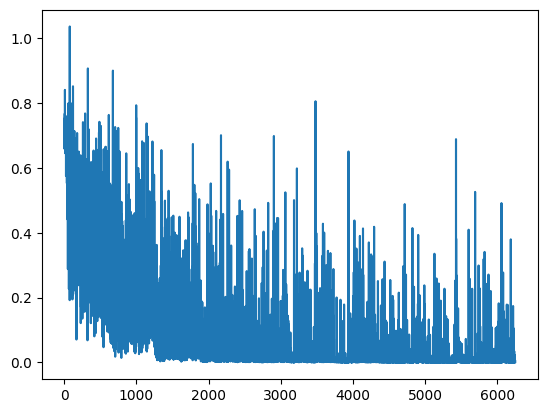

In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)), losses)
plt.show()

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["targets"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy on test set: {correct / total:.2%}")

Accuracy on test set: 85.30%


In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      logits = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(logits, targets.flatten())

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)

test_acc, mean_loss = eval_model(model, test_data_loader, loss_fn, device, len(test_dataset))
print(test_acc.item(), mean_loss)

0.858 0.7042991695814722
